# Marketing and Retail Analytics

OList is an e-commerce company that has faced some losses recently and they want to manage their inventory very well so as to reduce any unnecessary costs that they might be bearing. 

In this assignment, we need to manage the inventory cost of this e-commerce company. We need to identify top products that contribute to the revenue and also use market basket analysis to analyse the purchase behaviour of individual customers to estimate with relative certainty, what items are more likely to be purchased individually or in combination with some other products.

So ultimately, we need to help OList to identify the product categories which they can get rid of without significantly impacting business.

### Data Exploration and Cleaning

In this section - 

- We will read the provided data sets.
- We will identify missing and duplicate values in each column and will treat them accordingly. 
- Also, we will treat any data quality issues associated with the dataset.

In [1]:
#Import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read Order data

orders = pd.read_excel("Retail_dataset.xlsx", sheet_name="orders")
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-16 18:17:02,2018-02-26


In [3]:
# Check the shape

orders.shape

(99441, 7)

In [4]:
# Check column info

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_timestamp      96476 non-null  datetime64[ns]
 6   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](4), object(3)
memory usage: 5.3+ MB


In [5]:
# Check for any duplicated order id

orders.order_id.duplicated().sum()

0

In [6]:
# Check for duplicated customer id

orders.customer_id.duplicated().sum()

3345

##### This is expected as a single user can place multiple orders.

In [7]:
# Check the order status field

orders.order_status.value_counts(normalize = True) * 100

delivered      97.020344
shipped         1.113223
canceled        0.628513
unavailable     0.612423
invoiced        0.315765
processing      0.302692
created         0.005028
approved        0.002011
Name: order_status, dtype: float64

##### Since almost 97% of the records are of delivered status, for this case study we are going to consider only the orders which have been successfully delivered. 

In [8]:
# Keep the "delivered" orders and drop the rest

orders = orders[orders.order_status == 'delivered']

In [9]:
# Check the shape again

orders.shape

(96478, 7)

In [10]:
# Check for the order_status field

orders.order_status.value_counts()

delivered    96478
Name: order_status, dtype: int64

- Now, the order_status field has only one value that is 'delivered'. So, we are good to proceed.

In [11]:
# Check for any missing value

orders.isna().sum().sort_values(ascending=False)

order_approved_at                14
order_delivered_timestamp         8
order_estimated_delivery_date     0
order_purchase_timestamp          0
order_status                      0
customer_id                       0
order_id                          0
dtype: int64

We have two columns with missing values. Those are 'order_approved_at' and 'order_delivered_timestamp'.

Now, we can treat these missing values in 2 ways.

- _Option 1_: We can simply drop the records with missing values as the number of such records is very less.

- _Option 2_: We can assume that the order approval time and order delivery timestamp to be equivalent to/same as the order purchase timestamp and order estimated delivery date respectively. 

###### In this case we will go with option 2 since that would be our best and safest treatment method without losing the entire rows of data.


In [12]:
# Replace the missing values

orders.order_approved_at.fillna(orders.order_purchase_timestamp, inplace=True)

orders.order_delivered_timestamp.fillna(orders.order_estimated_delivery_date, inplace=True)

In [13]:
# Check for any missing value again

orders.isna().sum().sort_values(ascending=False)

order_estimated_delivery_date    0
order_delivered_timestamp        0
order_approved_at                0
order_purchase_timestamp         0
order_status                     0
customer_id                      0
order_id                         0
dtype: int64

- Everything looks good. Let's check the order_items data.

In [14]:
# Read the order_items data

order_items = pd.read_excel("Retail_dataset.xlsx", sheet_name="order_items")
order_items.head()

,order_id,order_item_id,product_id,seller_id,price,shipping_charges
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,18.14


In [15]:
# Check the shape

order_items.shape

(112650, 6)

In [16]:
# Check column info

order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   order_id          112650 non-null  object 
 1   order_item_id     112650 non-null  int64  
 2   product_id        112650 non-null  object 
 3   seller_id         112650 non-null  object 
 4   price             112650 non-null  float64
 5   shipping_charges  112650 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 5.2+ MB


In [17]:
# Check for any duplicates

order_items[['order_id','order_item_id']].duplicated().sum()

0

##### Here the combination of 'order_id' and 'order_item_id' should be unique.

In [18]:
# Check for missing values

order_items.isna().sum().sort_values(ascending=False)

shipping_charges    0
price               0
seller_id           0
product_id          0
order_item_id       0
order_id            0
dtype: int64

- No missing values. Let's explore the customers data.

In [19]:
# Read customers data

customers = pd.read_excel("Retail_dataset.xlsx", sheet_name="customers")
customers.head()

,customer_id,customer_zip_code_prefix,customer_city,customer_state
0,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [20]:
# Check the shape

customers.shape

(99441, 4)

In [21]:
# Check column info

customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_zip_code_prefix  99441 non-null  int64 
 2   customer_city             99441 non-null  object
 3   customer_state            99441 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.0+ MB


In [22]:
# Check for any duplicates

customers.customer_id.duplicated().sum()

3345

In [23]:
customers[customers.customer_id.duplicated()]

,customer_id,customer_zip_code_prefix,customer_city,customer_state
679,b6c083700ca8c135ba9f0f132930d4e8,8686,suzano,SP
1463,a40096fc0a3862e9e12bc55b5f8e6ab2,20561,rio de janeiro,RJ
1607,b8b3c435a58aebd788a477bed8342910,95585,arroio do sal,RS
2811,66980c3775537536f77b434d74e520f5,30290,belo horizonte,MG
3198,788313d21c3507fe890921f6e17aa679,11070,santos,SP
...,...,...,...,...
99324,8bab3162259edfaadd1ea2e1fe7f58dc,31565,belo horizonte,MG
99327,12ab9334b1240d6d037f2b0102a49571,38050,uberaba,MG
99336,0ee57f62666561b72f2ceacad0230cbf,9530,sao caetano do sul,SP
99353,0ceb502fc33a2ad327b08288c5310e2e,29134,viana,ES


- We have 3345 rows with duplicate data.
- To get rid of the duplicate records, we will only keep the first occurance of any such value and drop the rest (duplicated ones).

In [24]:
# Drop duplicate customer ids, keep only the first occurance

customers.drop_duplicates(subset="customer_id", keep="first", inplace=True)

In [25]:
# Check the shape again

customers.shape

(96096, 4)

In [26]:
# Check for any more duplicates

customers.customer_id.duplicated().sum()

0

In [27]:
# Check for missing vlaues

customers.isna().sum().sort_values(ascending=False)

customer_state              0
customer_city               0
customer_zip_code_prefix    0
customer_id                 0
dtype: int64

- We do not have any duplicates
- We do not have any missing value 

- Next, we wil read the payments information.

In [28]:
# Read the payments data

payments = pd.read_excel("Retail_dataset.xlsx", sheet_name="payments")
payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [29]:
# Check the shape

payments.shape

(103886, 5)

In [30]:
# Check column info

payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [31]:
# Check for any duplicates

payments[['order_id','payment_sequential']].duplicated().sum()

0

In [32]:
# Check for missing values

payments.isna().sum().sort_values(ascending=False)

payment_value           0
payment_installments    0
payment_type            0
payment_sequential      0
order_id                0
dtype: int64

- No duplicates or missing values found

- Let's explore products information

In [33]:
# Read products data

products = pd.read_excel("Retail_dataset.xlsx", sheet_name="products")
products.head()

,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,art,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,sports_leisure,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,baby,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,housewares,625.0,20.0,17.0,13.0


In [34]:
# Check the shape

products.shape

(32951, 6)

In [35]:
# Check column info

products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_id             32951 non-null  object 
 1   product_category_name  32781 non-null  object 
 2   product_weight_g       32949 non-null  float64
 3   product_length_cm      32949 non-null  float64
 4   product_height_cm      32949 non-null  float64
 5   product_width_cm       32949 non-null  float64
dtypes: float64(4), object(2)
memory usage: 1.5+ MB


In [36]:
# Check for any duplicates

products.product_id.duplicated().sum()

0

In [37]:
# Check for missing values

products.isna().sum().sort_values(ascending=False)

product_category_name    170
product_width_cm           2
product_height_cm          2
product_length_cm          2
product_weight_g           2
product_id                 0
dtype: int64

In [38]:
# Check the value count of product_category_name column

products.product_category_name.value_counts(normalize=True)*100

toys                                 75.424789
bed_bath_table                        2.406882
sports_leisure                        2.199445
furniture_decor                       2.095726
health_beauty                         1.976755
                                       ...    
home_comfort_2                        0.003051
fashion_childrens_clothes             0.003051
security_and_services                 0.003051
furniture_mattress_and_upholstery     0.003051
diapers_and_hygiene                   0.003051
Name: product_category_name, Length: 70, dtype: float64

##### Since 75% of the data belongs to 'toys' category, we can replace the missing values of product_category_name column with 'toys' 

In [39]:
# Replace the missing value with mode i.e. "toys"

products.product_category_name.fillna(products.product_category_name.mode()[0], inplace=True)


In [40]:
# Check for missing values again

products.isna().sum().sort_values(ascending=False)

product_width_cm         2
product_height_cm        2
product_length_cm        2
product_weight_g         2
product_category_name    0
product_id               0
dtype: int64

- The product width, height, length and weight are numerical values. Let's describe the data to see the distribution and other statistical values for these columns.

In [41]:
# Describe

products.describe()

,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32949.000000,32949.000000,32949.000000,32949.000000
mean,2276.472488,30.815078,16.937661,23.196728
std,4282.038731,16.914458,13.637554,12.079047
min,0.000000,7.000000,2.000000,6.000000
25%,300.000000,18.000000,8.000000,15.000000
50%,700.000000,25.000000,13.000000,20.000000
75%,1900.000000,38.000000,21.000000,30.000000
max,40425.000000,105.000000,105.000000,118.000000


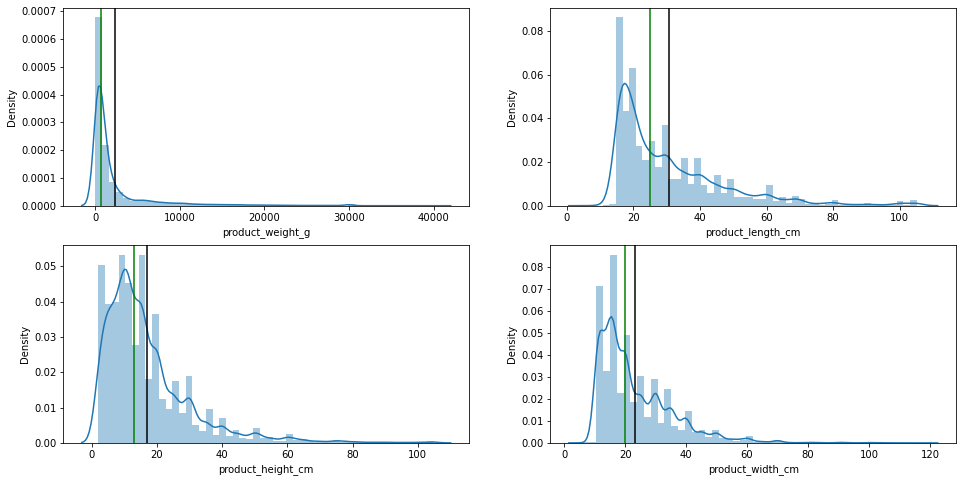

In [42]:
# Check the distribution

plt.figure(figsize=(16,8))

plt.subplot(2,2,1)
sns.distplot(products.product_weight_g)
plt.axvline(products.product_weight_g.mean(), color="black")
plt.axvline(products.product_weight_g.median(), color="green")
#plt.show()

plt.subplot(2,2,2)
sns.distplot(products.product_length_cm)
plt.axvline(products.product_length_cm.mean(), color="black")
plt.axvline(products.product_length_cm.median(), color="green")
#plt.show()

plt.subplot(2,2,3)
sns.distplot(products.product_height_cm)
plt.axvline(products.product_height_cm.mean(), color="black")
plt.axvline(products.product_height_cm.median(), color="green")
#plt.show()

plt.subplot(2,2,4)
sns.distplot(products.product_width_cm)
plt.axvline(products.product_width_cm.mean(), color="black")
plt.axvline(products.product_width_cm.median(), color="green")

plt.show()


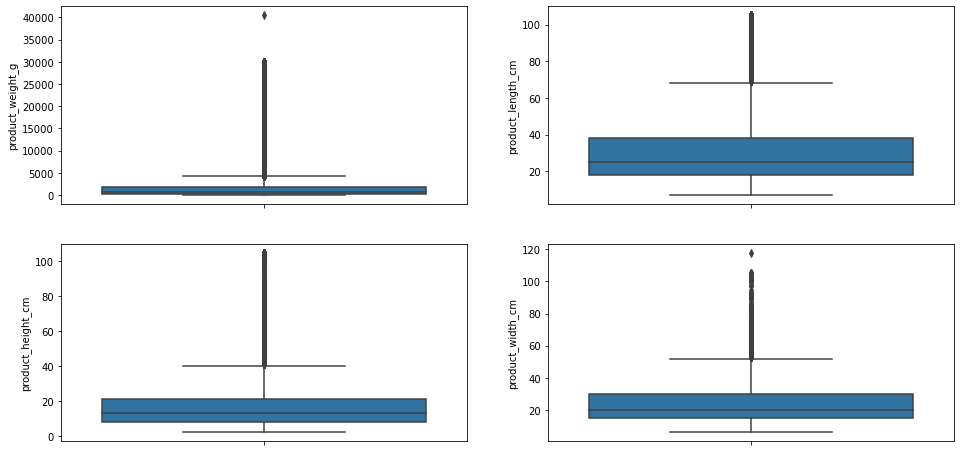

In [43]:
# Check the distribution

plt.figure(figsize=(16,8))

plt.subplot(2,2,1)
sns.boxplot(y= products.product_weight_g)

plt.subplot(2,2,2)
sns.boxplot(y= products.product_length_cm)

plt.subplot(2,2,3)
sns.boxplot(y= products.product_height_cm)

plt.subplot(2,2,4)
sns.boxplot(y= products.product_width_cm)


plt.show()


##### As we can see that the data is right-skewed and there is no significant outlier, instead of using mean, we will use the median to replace the missing values.

In [44]:
# Consider only the numerical columns for the missing value treatment

num_cols = products.describe().columns.to_list()
num_cols

['product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm']

In [45]:
for i in num_cols:
    products[i].fillna(products[i].median(), inplace=True)

In [46]:
# Check for missing values again

products.isna().sum().sort_values(ascending=False)

product_width_cm         0
product_height_cm        0
product_length_cm        0
product_weight_g         0
product_category_name    0
product_id               0
dtype: int64

##### Now that all data frames are free of duplicates and missing values, let's export each of them into new sheets.

In [47]:
# Create a Pandas Excel writer using XlsxWriter as the engine

writer = pd.ExcelWriter('Retail_Dataset_Cleaned.xlsx', engine='xlsxwriter')

In [48]:
# Write each dataframe to a different worksheet.

orders.to_excel(writer, sheet_name='Orders', index = False)
order_items.to_excel(writer, sheet_name='Order_items', index = False)
customers.to_excel(writer, sheet_name='Customers', index = False)
payments.to_excel(writer, sheet_name='Payments', index = False)
products.to_excel(writer, sheet_name='Products', index = False)

In [49]:
# Close the Pandas Excel writer and output the Excel file

writer.save()
print("Files exported successfully.")

Files exported successfully.


In [50]:
# Check if the export was successful

import os
os.getcwd()

'C:\\Users\\Chinmayee\\Desktop\\Upgrad\\Course 9 - Capstone Project\\Project Problem Statement'

##### NOTE: We will use this cleaned data file to build necessary visualisations and dashboard in Tableau.

# Market Basket Analysis

Market basket analysis is a technique which helps us do cross-selling effectively by building strategies using the data of the purchases. This is because cross-selling can help increase profits by recommending groups of similar items to consumers. Using market basket analysis, we try to identify the strength of association between two products. Market basket analysis would help us identify combinations of products which are bought frequently.

Here we will perform market basket analysis based on product_category_name

### Data Preparation

We will use the cleaned data set to prepare data for Market Basket analysis.

In [51]:
#Read Order_items data

df1 = pd.read_excel("Retail_Dataset_Cleaned.xlsx", sheet_name="Order_items")
df1.head()

,order_id,order_item_id,product_id,seller_id,price,shipping_charges
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,18.14


In [52]:
#Check the shape

df1.shape

(112650, 6)

In [53]:
# Read Products data

df2 = pd.read_excel("Retail_Dataset_Cleaned.xlsx", sheet_name="Products")
df2.head()

,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,225,16,10,14
1,3aa071139cb16b67ca9e5dea641aaa2f,art,1000,30,18,20
2,96bd76ec8810374ed1b65e291975717f,sports_leisure,154,18,9,15
3,cef67bcfe19066a932b7673e239eb23d,baby,371,26,4,26
4,9dc1a7de274444849c219cff195d0b71,housewares,625,20,17,13


In [54]:
# Check the shape

df2.shape

(32951, 6)

In [55]:
# Merge both data frames using the common column product_id

df = pd.merge(df1, df2, on = 'product_id', how = 'inner', indicator = True)
df.head()

,order_id,order_item_id,product_id,seller_id,price,shipping_charges,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,_merge
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,toys,650,28,9,14,both
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,55.9,17.96,toys,650,28,9,14,both
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,64.9,18.33,toys,650,28,9,14,both
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,16.17,toys,650,28,9,14,both
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,toys,650,28,9,14,both


In [56]:
# Check the shape of merged data frame

df.shape

(112650, 12)

In [57]:
# For our analysis we will only need the product category name and the order_id. 
# So, filter the data frame to have only the required columns

df = df[['order_id','product_category_name']]
df.head()

,order_id,product_category_name
0,00010242fe8c5a6d1ba2dd792cb16214,toys
1,130898c0987d1801452a8ed92a670612,toys
2,532ed5e14e24ae1f0d735b91524b98b9,toys
3,6f8c31653edb8c83e1a739408b5ff750,toys
4,7d19f4ef4d04461989632411b7e588b9,toys


In [58]:
# Check the shape again

df.shape

(112650, 2)

In [59]:
# # Create a Pandas Excel writer using XlsxWriter as the engine

writer = pd.ExcelWriter('Market_Basket_Analysis.xlsx', engine='xlsxwriter')

In [60]:
# Write the dataframe to two different worksheets as we need to create self-join in Tableau for Market Basket Analysis. 

df.to_excel(writer, sheet_name='Order_ProductCat_1', index = False)
df.to_excel(writer, sheet_name='Order_ProductCat_2', index = False)

In [61]:
# Close the Pandas Excel writer and output the Excel file

writer.save()
print("Files exported successfully.")

Files exported successfully.


In [62]:
# Check if the export was successful

import os
os.getcwd()

'C:\\Users\\Chinmayee\\Desktop\\Upgrad\\Course 9 - Capstone Project\\Project Problem Statement'

##### Next, we will use this data  file to perform Market Basket analysis and check the product category association in Tableau.